In [1]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('flights.csv') 
data, train_loader, val_loader, test_loader = get_data_loaders(data, 24, 10)
features = getFeatures()

<AxesSubplot: >

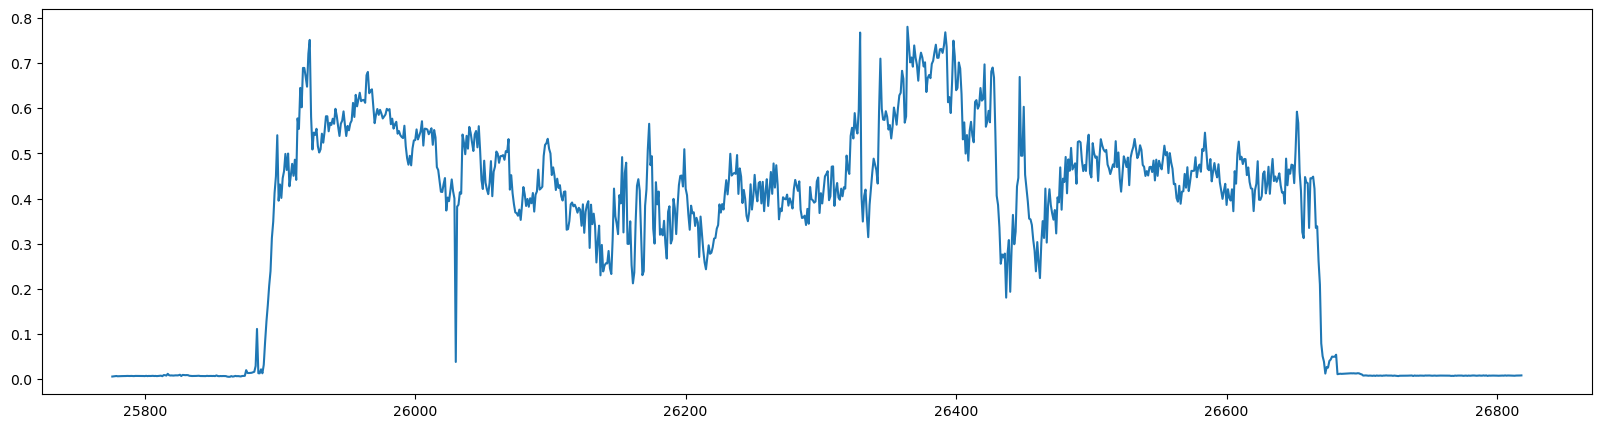

In [3]:
data[data['flight']==79]['power'].plot(figsize=(20, 5))

In [13]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 32])
torch.Size([64, 10])


In [4]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)

        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = self.fc(output) 
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(x)
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        outputs = self.decoder(xt, h, c) # (batch_size, output_len, 1)
        return outputs

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(features)
input_len = 24
output_len = 10
hidden_size = 32  
num_layers = 1

# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [64,64,64,64], hidden_size, num_layers=num_layers).to(device)

cuda


In [17]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.001)

# Training loop with validation and early stopping
num_epochs = 36
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.4f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.4f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_best_model_{input_len}-{output_len}.pt')


Epoch 1/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.23it/s, train_loss=3.13e+4]


Epoch 1/36, Average Training Loss: 32513.5883


Epoch 1/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.08it/s, val_loss=4.52e+4]


Epoch 1/36, Average Validation Loss: 33283.6952


Epoch 2/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 53.81it/s, train_loss=2.97e+4]


Epoch 2/36, Average Training Loss: 31570.7308


Epoch 2/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 132.51it/s, val_loss=4.14e+4]


Epoch 2/36, Average Validation Loss: 29172.5410


Epoch 3/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 53.79it/s, train_loss=1.62e+4]


Epoch 3/36, Average Training Loss: 32167.1970


Epoch 3/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 133.65it/s, val_loss=2.32e+4]


Epoch 3/36, Average Validation Loss: 22678.6447


Epoch 4/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.05it/s, train_loss=3.64e+4]


Epoch 4/36, Average Training Loss: 45174.2188


Epoch 4/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 134.41it/s, val_loss=4.82e+4]


Epoch 4/36, Average Validation Loss: 36540.1198


Epoch 5/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 52.92it/s, train_loss=2.69e+4]


Epoch 5/36, Average Training Loss: 33363.2803


Epoch 5/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.35it/s, val_loss=4.5e+4] 


Epoch 5/36, Average Validation Loss: 30828.5880


Epoch 6/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.47it/s, train_loss=3.41e+4]


Epoch 6/36, Average Training Loss: 30235.1976


Epoch 6/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.46it/s, val_loss=4.52e+4]


Epoch 6/36, Average Validation Loss: 30174.8028


Epoch 7/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.53it/s, train_loss=2.63e+4]


Epoch 7/36, Average Training Loss: 26206.5891


Epoch 7/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.48it/s, val_loss=2.99e+4]


Epoch 7/36, Average Validation Loss: 22153.7841


Epoch 8/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.17it/s, train_loss=1.64e+4]


Epoch 8/36, Average Training Loss: 25273.0300


Epoch 8/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.20it/s, val_loss=2.76e+4]


Epoch 8/36, Average Validation Loss: 20843.8088


Epoch 9/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.58it/s, train_loss=1.67e+4]


Epoch 9/36, Average Training Loss: 19394.4688


Epoch 9/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 134.74it/s, val_loss=2.68e+4]


Epoch 9/36, Average Validation Loss: 19663.5617


Epoch 10/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 53.92it/s, train_loss=1.37e+4]


Epoch 10/36, Average Training Loss: 18242.3476


Epoch 10/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 133.49it/s, val_loss=2.09e+4]


Epoch 10/36, Average Validation Loss: 16197.4148


Epoch 11/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.07it/s, train_loss=1.37e+4]


Epoch 11/36, Average Training Loss: 15656.0430


Epoch 11/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 133.93it/s, val_loss=2.34e+4]


Epoch 11/36, Average Validation Loss: 16851.1688


Epoch 12/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 53.20it/s, train_loss=1.51e+4]


Epoch 12/36, Average Training Loss: 18267.9399


Epoch 12/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 133.17it/s, val_loss=2.04e+4]


Epoch 12/36, Average Validation Loss: 15873.3251


Epoch 13/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 53.87it/s, train_loss=1.76e+4]


Epoch 13/36, Average Training Loss: 17988.3186


Epoch 13/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 130.42it/s, val_loss=3.03e+4]


Epoch 13/36, Average Validation Loss: 23361.2411


Epoch 14/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 53.76it/s, train_loss=1.66e+4]


Epoch 14/36, Average Training Loss: 18036.4475


Epoch 14/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 134.10it/s, val_loss=2.05e+4]


Epoch 14/36, Average Validation Loss: 16004.9345


Epoch 15/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.49it/s, train_loss=1.09e+4]


Epoch 15/36, Average Training Loss: 20030.4150


Epoch 15/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.89it/s, val_loss=2.55e+4]


Epoch 15/36, Average Validation Loss: 18168.6384


Epoch 16/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.50it/s, train_loss=1.56e+4]


Epoch 16/36, Average Training Loss: 17256.3916


Epoch 16/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 134.97it/s, val_loss=1.6e+4] 


Epoch 16/36, Average Validation Loss: 12767.3249


Epoch 17/36 [TRAIN]: 100%|██████████| 2418/2418 [00:46<00:00, 51.84it/s, train_loss=1.6e+4] 


Epoch 17/36, Average Training Loss: 16459.0223


Epoch 17/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 123.83it/s, val_loss=2.58e+4]


Epoch 17/36, Average Validation Loss: 18881.8532


Epoch 18/36 [TRAIN]: 100%|██████████| 2418/2418 [00:46<00:00, 51.57it/s, train_loss=1.07e+4]


Epoch 18/36, Average Training Loss: 15261.7530


Epoch 18/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.51it/s, val_loss=1.44e+4]


Epoch 18/36, Average Validation Loss: 12324.8918


Epoch 19/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 52.86it/s, train_loss=1.11e+4]


Epoch 19/36, Average Training Loss: 12775.2434


Epoch 19/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 132.14it/s, val_loss=1.44e+4]


Epoch 19/36, Average Validation Loss: 13821.0187


Epoch 20/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 53.39it/s, train_loss=1.12e+4]


Epoch 20/36, Average Training Loss: 13451.5196


Epoch 20/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 133.17it/s, val_loss=1.36e+4]


Epoch 20/36, Average Validation Loss: 12668.7657


Epoch 21/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.36it/s, train_loss=1.06e+4]


Epoch 21/36, Average Training Loss: 14745.4852


Epoch 21/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.00it/s, val_loss=1.3e+4] 


Epoch 21/36, Average Validation Loss: 11864.7032


Epoch 22/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.06it/s, train_loss=1.39e+4]


Epoch 22/36, Average Training Loss: 12711.9380


Epoch 22/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 134.52it/s, val_loss=1.59e+4]


Epoch 22/36, Average Validation Loss: 13405.8002


Epoch 23/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.28it/s, train_loss=1.34e+4]


Epoch 23/36, Average Training Loss: 12103.4379


Epoch 23/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.21it/s, val_loss=1.36e+4]


Epoch 23/36, Average Validation Loss: 11469.8690


Epoch 24/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 53.49it/s, train_loss=1.97e+4]


Epoch 24/36, Average Training Loss: 15550.8752


Epoch 24/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.61it/s, val_loss=1.68e+4]


Epoch 24/36, Average Validation Loss: 14954.6059


Epoch 25/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 53.84it/s, train_loss=1.02e+4]


Epoch 25/36, Average Training Loss: 12350.1255


Epoch 25/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 134.42it/s, val_loss=15710.0]


Epoch 25/36, Average Validation Loss: 12862.0939


Epoch 26/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.33it/s, train_loss=1.17e+4]


Epoch 26/36, Average Training Loss: 12517.2782


Epoch 26/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 136.48it/s, val_loss=1.35e+4]


Epoch 26/36, Average Validation Loss: 11184.1419


Epoch 27/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.47it/s, train_loss=7.49e+3]


Epoch 27/36, Average Training Loss: 11669.3157


Epoch 27/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.48it/s, val_loss=1.29e+4]


Epoch 27/36, Average Validation Loss: 10793.2408


Epoch 28/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.48it/s, train_loss=9.87e+3]


Epoch 28/36, Average Training Loss: 11826.0012


Epoch 28/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 135.34it/s, val_loss=1.88e+4]


Epoch 28/36, Average Validation Loss: 14018.5145


Epoch 29/36 [TRAIN]: 100%|██████████| 2418/2418 [00:46<00:00, 51.63it/s, train_loss=1.12e+4]


Epoch 29/36, Average Training Loss: 15264.6273


Epoch 29/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 130.88it/s, val_loss=1.45e+4]


Epoch 29/36, Average Validation Loss: 12642.7722


Epoch 30/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 53.34it/s, train_loss=1.78e+4]


Epoch 30/36, Average Training Loss: 11906.8789


Epoch 30/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 132.71it/s, val_loss=1.37e+4]


Epoch 30/36, Average Validation Loss: 11234.4374


Epoch 31/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 53.88it/s, train_loss=10070.0]


Epoch 31/36, Average Training Loss: 11255.3582


Epoch 31/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 132.98it/s, val_loss=1.17e+4]


Epoch 31/36, Average Validation Loss: 9746.7087


Epoch 32/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 53.59it/s, train_loss=8.28e+3]


Epoch 32/36, Average Training Loss: 9935.4123


Epoch 32/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 133.39it/s, val_loss=1.53e+4]


Epoch 32/36, Average Validation Loss: 11928.4263


Epoch 33/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 53.28it/s, train_loss=2.23e+4]


Epoch 33/36, Average Training Loss: 13408.2184


Epoch 33/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 136.65it/s, val_loss=2.49e+4]


Epoch 33/36, Average Validation Loss: 22183.3555


Epoch 34/36 [TRAIN]: 100%|██████████| 2418/2418 [00:44<00:00, 54.23it/s, train_loss=2.33e+4]


Epoch 34/36, Average Training Loss: 22868.2386


Epoch 34/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 128.33it/s, val_loss=2.13e+4]


Epoch 34/36, Average Validation Loss: 22521.3404


Epoch 35/36 [TRAIN]: 100%|██████████| 2418/2418 [00:45<00:00, 53.01it/s, train_loss=1.17e+4]


Epoch 35/36, Average Training Loss: 13585.9083


Epoch 35/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 146.50it/s, val_loss=1.34e+4]


Epoch 35/36, Average Validation Loss: 12547.0612


Epoch 36/36 [TRAIN]: 100%|██████████| 2418/2418 [00:42<00:00, 56.56it/s, train_loss=1.07e+4]


Epoch 36/36, Average Training Loss: 12370.5720


Epoch 36/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 140.07it/s, val_loss=1.24e+4]

Epoch 36/36, Average Validation Loss: 11093.5925


Test loss: 0.0019065240630879998
MAPE: 8.984930038452148


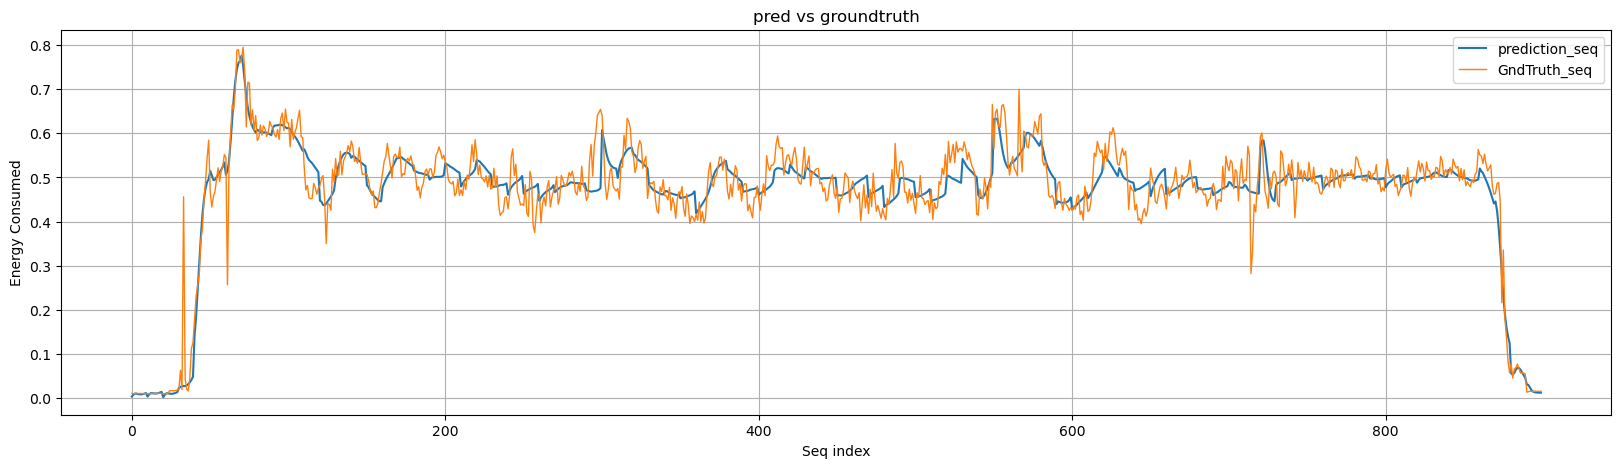

In [14]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load('TCN_LSTM_best_model_24-10.pt'))

# Test the model
seq2seq.eval()
flight_num = random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[features].values, 
                                         test_data['power'].values,24,10)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""